In [205]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set a random seed to ensure consistent results and minimize significant variations.

In [206]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [207]:
train_doc = np.random.permutation(open('C:/Users/fg722f/dataset/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/fg722f/dataset/Project_data/val.csv').readlines())
batch_size = 8

Generator Overview 

The generator plays a pivotal role in deep learning models, especially in tasks involving image sequences, such as video or gesture recognition. It efficiently preprocesses and batches images for training, managing varying image dimensions and ensuring proper normalization for optimal performance.

In your specific task, the generator needs to handle two different image dimensions and create a batch of video frames. You will be experimenting with parameters like img_idx, y, and z, which are critical for data preprocessing and shaping the input for the model. These parameters help in organizing and formatting your data in a way that leads to better accuracy.

In [208]:
# Set parameters
total_frames = 30  # Total number of frames in a video sequence
num_frames = 15    # Number of frames to select per video
gestures = 5       # Number of gesture classes
image_height = 100 # Height of the images
image_width = 100  # Width of the images

# Generate the frame indices (img_idx)
img_idx = np.round(np.linspace(0, total_frames - 1, num_frames)).astype(int)

# Define the batch size
batch_size = 8

In [209]:
from skimage.io import imread
from skimage.transform import resize

def resize_crop_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))
        
    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

In [210]:
from matplotlib import pyplot as plt

def show_resize_crop_image(paths):

    for index, path in enumerate(paths):
        plt.figure(figsize=(20,20))
            
        plt.subplot(5, 2, index*2+1)
        image = resize_crop_image(imread(path))
        plt.imshow(image)
        plt.title('Modified')
        
        plt.subplot(5, 2, index*2+2)
        plt.imshow(imread(path))
        plt.title('Original')
                
    plt.show()

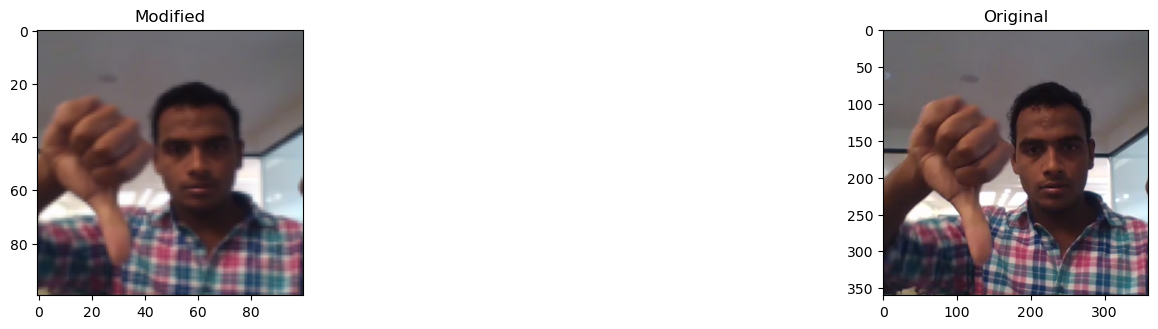

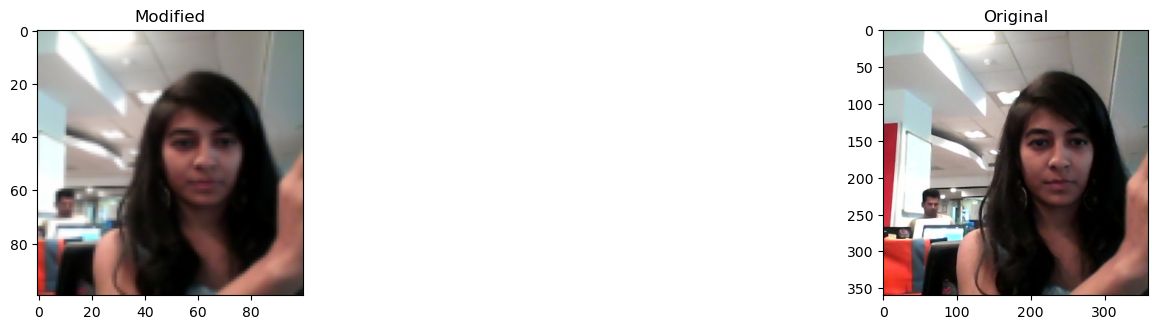

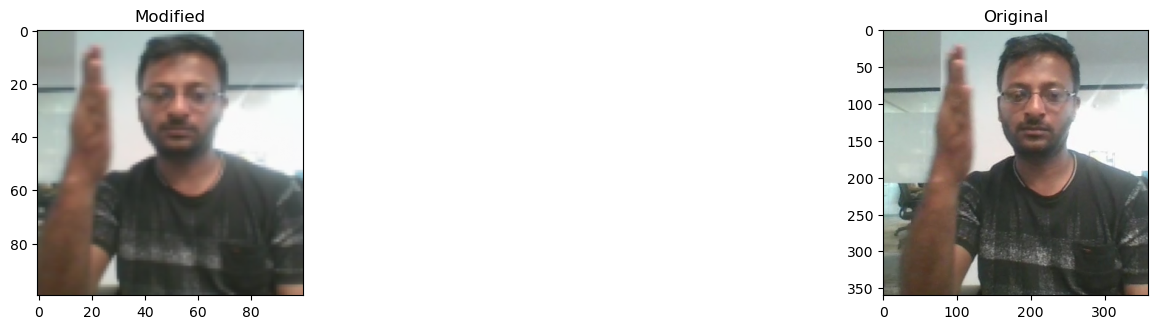

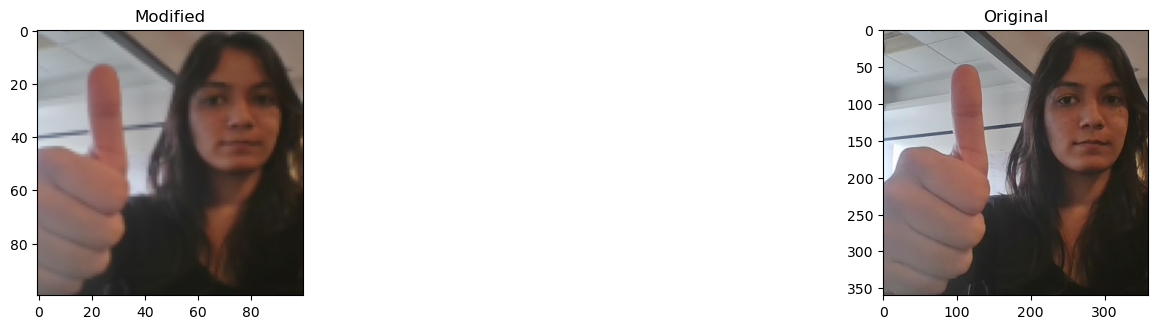

In [211]:
paths = ["C:/Users/fg722f/dataset/Project_data/train/WIN_20180907_15_38_35_Pro_Thumbs Down_new/WIN_20180907_15_38_35_Pro_00032.png",
        "C:/Users/fg722f/dataset/Project_data/train/WIN_20180907_15_56_38_Pro_Right Swipe_new/WIN_20180907_15_56_38_Pro_00013.png",
        "C:/Users/fg722f/dataset/Project_data/train/WIN_20180907_15_38_17_Pro_Left Swipe_new_Left Swipe_new/WIN_20180907_15_38_17_Pro_00069.png",
        "C:/Users/fg722f/dataset/Project_data/train/WIN_20180907_15_53_12_Pro_Thumbs Up_new/WIN_20180907_15_53_12_Pro_00037.png"]

show_resize_crop_image(paths)

In [212]:
def generator(source_path, folder_list, batch_size, img_idx, image_height, image_width, gestures):
    print('Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)  # Ensure that t is initialized here
        num_batches = len(folder_list) // batch_size
        for batch in range(num_batches):  # Iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3))  # Initialize batch_data
            batch_labels = np.zeros((batch_size, gestures))  # Initialize batch_labels
            for folder in range(batch_size):  # Iterate over the batch_size
                index = folder + (batch * batch_size)
                if index >= len(t):  # Check if the index is out of range
                    break  # Or handle this scenario appropriately (e.g., continue or stop)
                imgs = os.listdir(source_path + '/' + t[index].split(';')[0])  # Read all images in the folder
                for idx, item in enumerate(img_idx):  # Iterate over the frames/images of a folder to read them
                    image = imread(source_path + '/' + t[index].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    
                    # Crop and resize the image
                    image = resize_crop_image(image)
                    
                    # Assign the image to the batch_data
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]  # Normalize and feed in the image
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]  # Normalize and feed in the image
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]  # Normalize and feed in the image

                # One-hot encode the label for the current folder
                label = int(t[index].strip().split(';')[2])  # Make sure index is within range
                batch_labels[folder, label] = 1  # Set the correct label to 1

            yield batch_data, batch_labels  # Yield the batch_data and batch_labels


In [213]:
# Get current date and time
curr_dt_time = datetime.datetime.now()

# Define paths for training and validation data
train_path = 'C:/Users/fg722f/dataset/Project_data/train'
val_path = 'C:/Users/fg722f/dataset/Project_data/val'

# Get the list of all files in the training and validation directories
train_doc = os.listdir(train_path)
val_doc = os.listdir(val_path)

# Number of sequences in the training and validation datasets
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# Define the number of epochs for training
num_epochs = 25
print('# epochs =', num_epochs)

# Print current date and time
print('Current date and time:', curr_dt_time)


# training sequences = 663
# validation sequences = 100
# epochs = 25
Current date and time: 2025-03-01 12:03:24.813896


Model 

To design an efficient 3D convolutional model using Keras for gesture recognition, we will use Conv3D and MaxPooling3D layers to work with 3D data (i.e., sequences of frames from videos). I'll also walk you through building the model with a structure that allows good accuracy while ensuring the number of parameters is kept low so that it can fit within the memory constraints of your device.

Experiment 1

In [214]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers


# Define the number of gesture classes (ensure this is defined)
gestures = 10  # For example, 10 gestures

# Define the model
model = Sequential()

# First Conv3D block
model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Conv3D block
model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Conv3D block
model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the 3D output to 1D
model.add(Flatten())

# Fully connected layer with dropout for regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

# Another dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

# Output softmax layer (for multi-class classification)
model.add(Dense(gestures, activation='softmax'))


In [215]:
# Compile the model with Adam optimizer
model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [216]:
# Print model summary
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_60 (Conv3D)                   │ (None, 15, 100, 100, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 15, 100, 100, 32)    │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_60 (Activation)           │ (None, 15, 100, 100, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_60 (MaxPooling3D)      │ (None, 7, 50, 50, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_61 (Conv3D)                   │ (None, 7, 50, 50, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_61               │ (None, 7, 50, 50, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_61 (Activation)           │ (None, 7, 50, 50, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_61 (MaxPooling3D)      │ (None, 3, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_62 (Conv3D)                   │ (None, 3, 25, 25, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_62               │ (None, 3, 25, 25, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_62 (Activation)           │ (None, 3, 25, 25, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_62 (MaxPooling3D)      │ (None, 1, 12, 12, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,648,522 (10.10 MB)

 Trainable params: 2,648,074 (10.10 MB)

 Non-trainable params: 448 (1.75 KB)

In [217]:


# Now, call the generator and pass the required arguments
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_height, image_width, gestures)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_height, image_width, gestures)


In [218]:
model_name = 'model_init_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [219]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [220]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

TypeError: TensorFlowTrainer.fit() got an unexpected keyword argument 'workers'

In [ ]:
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

def plot_history(history, num_epochs):
    # Display training and validation accuracy at the last epoch
    display(Markdown("**Training Accuracy:** " + str(round(history.history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(history.history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))

    # Access the history metrics dynamically in case of different naming conventions
    acc = history.history.get('categorical_accuracy', [])
    val_acc = history.history.get('val_categorical_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    epochs_range = range(num_epochs)

    # Plot accuracy and loss
    plt.figure(figsize=(15, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Example usage:
history = model.fit(  # Your model training code
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    workers=4,
    initial_epoch=0
)

# After training, call plot_history and pass the number of epochs
plot_history(history, num_epochs)


Experiment 2

Reducing the size of the image from 100 to 50


In [ ]:

show_resize_crop_image(paths)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, BatchNormalization, Activation, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model architecture
model = Sequential()

# 1st Conv3D Block
model.add(Conv3D(8, kernel_size=(3, 3, 3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 2nd Conv3D Block
model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 3rd Conv3D Block
model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten layer to feed into Dense layers
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output Layer (Softmax for multi-class classification)
model.add(Dense(gestures, activation='softmax'))


In [ ]:
from tensorflow.keras import optimizers

# Create the SGD optimizer with the correct API (using 'learning_rate' instead of 'lr')
optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# Compile the model with the SGD optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())


In [ ]:
# Set parameters
total_frames = 30  # Total number of frames in a video sequence
num_frames = 15    # Number of frames to select per video
gestures = 5       # Number of gesture classes
image_height = 50 # Height of the images
image_width = 50  # Width of the images

# Generate the frame indices (img_idx)
img_idx = np.round(np.linspace(0, total_frames - 1, num_frames)).astype(int)

# Define the batch size
batch_size = 8 # Define your batch size (e.g., 32)

# Call the generator function with all required parameters
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_height, image_width, gestures)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_height, image_width, gestures)


In [ ]:
model_name = 'model_exp2_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_history(history)

Experiment 3 

Reducing the size of the image from 50 to 25

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, BatchNormalization, Activation, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model architecture
model = Sequential()

# 1st Conv3D Block
model.add(Conv3D(8, kernel_size=(3, 3, 3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 2nd Conv3D Block
model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 3rd Conv3D Block
model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten layer to feed into Dense layers
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output Layer (Softmax for multi-class classification)
model.add(Dense(gestures, activation='softmax'))


In [ ]:
# Create the SGD optimizer with the correct API (using 'learning_rate' instead of 'lr')
optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# Compile the model with the SGD optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())

In [ ]:
# Set parameters
total_frames = 30  # Total number of frames in a video sequence
num_frames = 15    # Number of frames to select per video
gestures = 5       # Number of gesture classes
image_height = 25 # Height of the images
image_width = 25  # Width of the images

# Generate the frame indices (img_idx)
img_idx = np.round(np.linspace(0, total_frames - 1, num_frames)).astype(int)

# Define the batch size
batch_size = 8 

# Call the generator function with all required parameters
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_height, image_width, gestures)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_height, image_width, gestures)

In [ ]:
model_name = 'model_exp2_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_history(history)

Experiment 4


Decreasing the batch size from 8 to 4

In [ ]:
show_resize_crop_image(paths)

In [ ]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [ ]:
from tensorflow.keras import optimizers

# Define the optimizer
optimiser = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# Compile the model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print model summary
print(model.summary())


In [ ]:
# Set parameters
total_frames = 30  # Total number of frames in a video sequence
num_frames = 15    # Number of frames to select per video
gestures = 5       # Number of gesture classes
image_height = 100 # Height of the images
image_width = 100  # Width of the images

# Generate the frame indices (img_idx)
img_idx = np.round(np.linspace(0, total_frames - 1, num_frames)).astype(int)

# Define the batch size
batch_size = 4  

# Call the generator function with all required parameters
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_height, image_width, gestures)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_height, image_width, gestures)


In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_history(history)

Experiment 5

Changing the optmizer from SGD to Adam

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, BatchNormalization, Activation, MaxPooling3D, Flatten, Dense, Dropout

# Define the model
model = Sequential()

# First Conv3D layer
model.add(Conv3D(8, kernel_size=(3, 3, 3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Conv3D layer
model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Conv3D layer
model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layer with Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Second Dense layer with Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Softmax output layer
model.add(Dense(gestures, activation='softmax'))

# Define the optimizer using the correct argument
optimiser = optimizers.Adam(learning_rate=0.0002)




In [ ]:

# Compile the model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())

In [ ]:
# Set parameters
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs = 25

# Define paths for training and validation
train_path = 'path_to_train_data'  # Replace with the actual path to your training data
val_path = 'path_to_val_data'      # Replace with the actual path to your validation data

# Ensure you pass all required arguments to the generator function
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_height, image_width, gestures)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_height, image_width, gestures)


In [ ]:
model_name = 'model_exp5_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_history(history)

Experiment 6

Reducing the number of frames from 15 to 10

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, BatchNormalization, Activation, MaxPooling3D, Flatten, Dense, Dropout

# Define the model
model = Sequential()

# First Conv3D layer
model.add(Conv3D(8, kernel_size=(3, 3, 3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Conv3D layer
model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Conv3D layer
model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layer with Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Second Dense layer with Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Softmax output layer
model.add(Dense(gestures, activation='softmax'))

# Corrected optimizer with 'learning_rate' argument
optimiser = optimizers.Adam(learning_rate=0.0002)


In [ ]:
# Compile the model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print model summary
print(model.summary())

In [ ]:
# Set parameters
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs = 25

# Define paths for training and validation
train_path = 'path_to_train_data'  # Replace with the actual path to your training data
val_path = 'path_to_val_data'      # Replace with the actual path to your validation data

# Ensure you pass all required arguments to the generator function
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_height, image_width, gestures)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_height, image_width, gestures)

In [ ]:
model_name = 'model_exp6_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_history(history)

Experiment 7
Reducing the dropout rate from 0.5 to 0.25

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, BatchNormalization, Activation, MaxPooling3D, Flatten, Dense, Dropout

# Define the model
model = Sequential()

# First Conv3D layer
model.add(Conv3D(8, kernel_size=(3, 3, 3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Conv3D layer
model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Conv3D layer
model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layer with Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

# Second Dense layer with Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

# Softmax output layer
model.add(Dense(gestures, activation='softmax'))

# Optimizer with 'learning_rate' argument
optimiser = optimizers.Adam(learning_rate=0.0002)

# Compile the model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print model summary
print(model.summary())


In [ ]:
# Set parameters
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs = 25

# Define paths for training and validation
train_path = 'path_to_train_data'  # Replace with the actual path to your training data
val_path = 'path_to_val_data'      # Replace with the actual path to your validation data

# Ensure you pass all required arguments to the generator function
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_height, image_width, gestures)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_height, image_width, gestures)

In [ ]:
model_name = 'model_exp7_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_history(history)

Experiment 8
Increasing the number of epochs from 25 to 35

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, BatchNormalization, Activation, MaxPooling3D, Flatten, Dense, Dropout

# Define the model
model = Sequential()

# First Conv3D layer
model.add(Conv3D(8, kernel_size=(3, 3, 3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Conv3D layer
model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Conv3D layer
model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layer with Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

# Second Dense layer with Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

# Softmax output layer
model.add(Dense(gestures, activation='softmax'))

# Optimizer with 'learning_rate' argument
optimiser = optimizers.Adam(learning_rate=0.0002)

# Compile the model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print model summary
print(model.summary())

In [ ]:
# Set parameters
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs = 25

# Define paths for training and validation
train_path = 'path_to_train_data'  # Replace with the actual path to your training data
val_path = 'path_to_val_data'      # Replace with the actual path to your validation data

# Ensure you pass all required arguments to the generator function
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_height, image_width, gestures)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_height, image_width, gestures)

In [ ]:
model_name = 'model_exp8_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_history(history)